In [15]:
import pandas

df = pandas.read_csv('./data/mental_health_wearable_data.csv')

In [16]:
df.shape

(10000, 5)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Heart_Rate_BPM           10000 non-null  int64  
 1   Sleep_Duration_Hours     10000 non-null  float64
 2   Physical_Activity_Steps  10000 non-null  int64  
 3   Mood_Rating              10000 non-null  int64  
 4   Mental_Health_Condition  10000 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 390.8 KB


In [18]:
df.head()

,Heart_Rate_BPM,Sleep_Duration_Hours,Physical_Activity_Steps,Mood_Rating,Mental_Health_Condition
0,98,7.425124,13760,5,1
1,111,9.457572,11455,9,0
2,88,4.037103,9174,8,1
3,74,8.864101,12612,1,1
4,102,9.690217,3923,9,0


In [19]:
df.tail()

,Heart_Rate_BPM,Sleep_Duration_Hours,Physical_Activity_Steps,Mood_Rating,Mental_Health_Condition
9995,107,7.517607,11087,8,1
9996,82,8.195159,4579,7,0
9997,65,7.151055,11825,1,0
9998,110,9.008428,14175,9,1
9999,112,4.198801,3379,4,0


In [20]:
df.describe()

,Heart_Rate_BPM,Sleep_Duration_Hours,Physical_Activity_Steps,Mood_Rating,Mental_Health_Condition
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,89.822000,6.978495,8061.81200,5.065100,0.515700
std,17.309144,1.730834,4067.11812,2.562522,0.499778
min,60.000000,4.000317,1000.00000,1.000000,0.000000
25%,75.000000,5.474809,4468.75000,3.000000,0.000000
50%,90.000000,6.951605,8116.00000,5.000000,1.000000
75%,105.000000,8.492401,11617.25000,7.000000,1.000000
max,119.000000,9.998831,14998.00000,9.000000,1.000000


In [21]:
df.isnull().sum()

Heart_Rate_BPM             0
Sleep_Duration_Hours       0
Physical_Activity_Steps    0
Mood_Rating                0
Mental_Health_Condition    0
dtype: int64

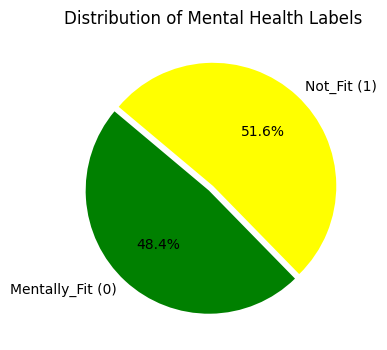

In [22]:
import matplotlib.pyplot as plt

labels_count = df['Mental_Health_Condition'].value_counts()

labels = ['Mentally_Fit (0)','Not_Fit (1)']
sizes = [labels_count[0],labels_count[1]]
colors = ['green','yellow']
explode = (0.05,0)

# Creating the pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title('Distribution of Mental Health Labels')
plt.show()

In [ ]:
# Heart Rate Variability (using standard deviation as a simple measure)
heart_rate_std = df.groupby(df.index // 24)['Heart_Rate_BPM'].std().reset_index()
heart_rate_std.columns = ['day', 'heart_rate_variability'] 
df = df.join(heart_rate_std.set_index('day'), on=df.index // 24)

# Sleep Efficiency (assuming ideal sleep is 8 hours)
df['sleep_efficiency'] = df['Sleep_Duration_Hours'] / 8

# Activity Consistency (using rolling window)
df['activity_7day_avg'] = df['Physical_Activity_Steps'].rolling(window=7, min_periods=1).mean()
df['activity_consistency'] = abs(df['Physical_Activity_Steps'] - df['activity_7day_avg'])

# Additional derived features
df['activity_intensity'] = df['Physical_Activity_Steps'] / (df['Sleep_Duration_Hours'] * 60)  # steps per minute of awake time
df['stress_indicator'] = (df['Heart_Rate_BPM'] * (10 - df['Sleep_Duration_Hours'])) / 100

# 2.3 Normalization and Aggregation
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# List of columns to normalize
columns_to_normalize = ['Heart_Rate_BPM', 'Sleep_Duration_Hours', 'Physical_Activity_Steps', 
                       'heart_rate_variability', 'activity_consistency', 'activity_intensity',
                       'stress_indicator']

# Normalize the selected columns
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Weekly aggregations
weekly_stats = df.groupby(df.index // 7).agg({
    'Heart_Rate_BPM': ['mean', 'std'],
    'Sleep_Duration_Hours': ['mean', 'min'],
    'Physical_Activity_Steps': ['mean', 'sum'],
    'Mood_Rating': 'mean',
    'stress_indicator': 'mean'
}).round(2)

# Flatten column names
weekly_stats.columns = ['_'.join(col).strip() for col in weekly_stats.columns.values]

print("\nFeature Engineering Complete. New features added:")
print("\nOriginal shape:", df.shape)
print("Shape after adding features:", df_normalized.shape)
print("\nSample of weekly aggregated stats:")
print(weekly_stats.head())



Feature Engineering Complete. New features added:

Original shape: (10000, 12)
Shape after adding features: (10000, 12)

Sample of weekly aggregated stats:
   Heart_Rate_BPM_mean  Heart_Rate_BPM_std  Sleep_Duration_Hours_mean  \
0                88.57               15.94                       7.00   
1                85.43               16.85                       7.13   
2                92.00               18.07                       7.35   
3                87.57               21.41                       7.37   
4                89.71               15.70                       7.13   

   Sleep_Duration_Hours_min  Physical_Activity_Steps_mean  \
0                      4.04                       9658.43   
1                      4.09                       8281.71   
2                      5.01                       6745.29   
3                      5.36                      10152.71   
4                      5.02                       7251.14   

   Physical_Activity_Steps_sum  Mood_

In [24]:
# Model Selection and Training

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
features = ['Heart_Rate_BPM', 'Sleep_Duration_Hours', 'Physical_Activity_Steps', 
           'heart_rate_variability', 'sleep_efficiency', 'activity_consistency',
           'activity_intensity', 'stress_indicator']

X = df_normalized[features]
y = df['Mental_Health_Condition']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


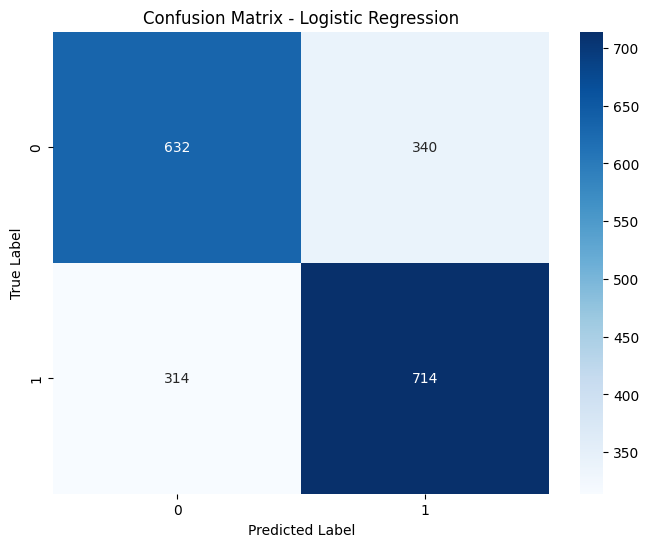


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       972
           1       0.68      0.69      0.69      1028

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



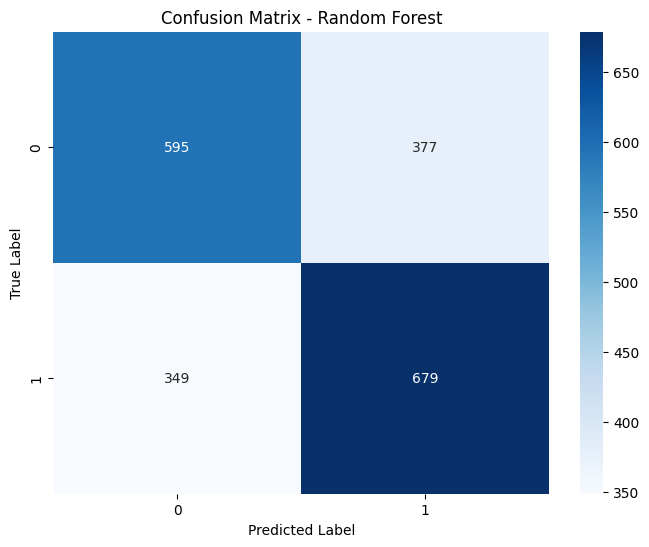


Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       972
           1       0.64      0.66      0.65      1028

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000



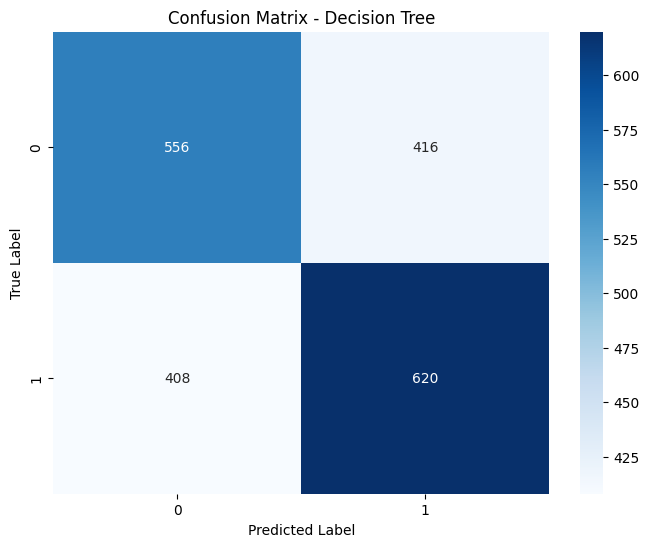


Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.58      0.57      0.57       972
           1       0.60      0.60      0.60      1028

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000



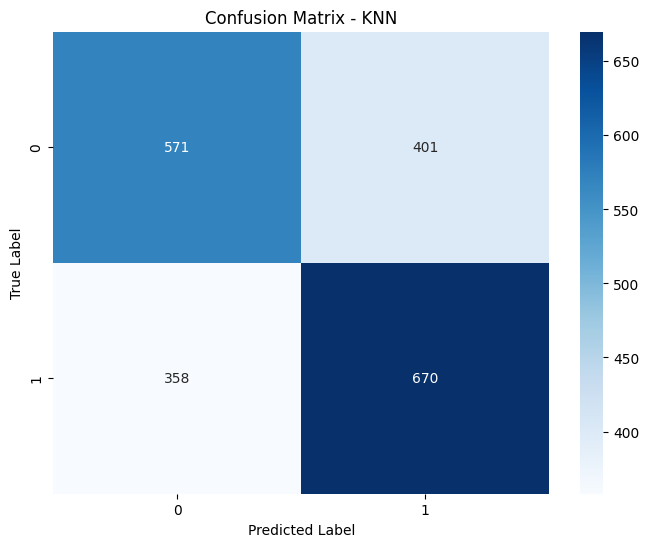


Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       972
           1       0.63      0.65      0.64      1028

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000



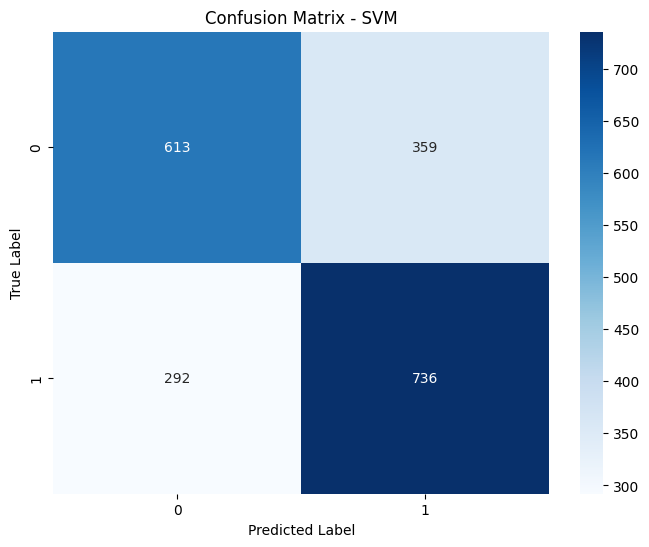


Classification Report - SVM:
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       972
           1       0.67      0.72      0.69      1028

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



In [26]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(random_state=42, probability=True)
}

# Train models and collect results
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print(f"\nClassification Report - {name}:")
    print(results[name]['classification_report'])



Ensemble Model Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       972
           1       0.65      0.68      0.67      1028

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



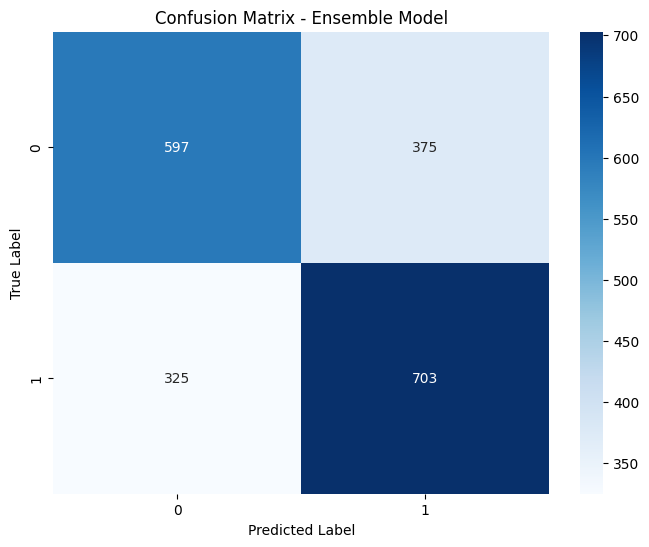

<Figure size 1200x1200 with 0 Axes>

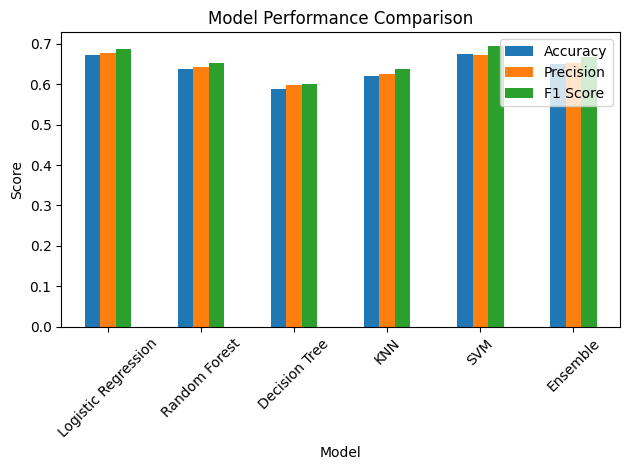

In [ ]:
import pandas as pd

# Create ensemble model
estimators = [(name, model) for name, model in models.items()]
ensemble = VotingClassifier(estimators=estimators, voting='soft')
ensemble.fit(X_train, y_train)

# Make predictions with ensemble
y_pred_ensemble = ensemble.predict(X_test)

# Calculate and display ensemble results
print("\nEnsemble Model Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_ensemble), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Compare model performances
performance_df = pd.DataFrame({
    'Model': list(results.keys()) + ['Ensemble'],
    'Accuracy': [results[model]['accuracy'] for model in results.keys()] + [accuracy_score(y_test, y_pred_ensemble)],
    'Precision': [results[model]['precision'] for model in results.keys()] + [precision_score(y_test, y_pred_ensemble)],
    'F1 Score': [results[model]['f1'] for model in results.keys()] + [f1_score(y_test, y_pred_ensemble)]
})

# Plot performance comparison
plt.figure(figsize=(12, 6))
performance_df.set_index('Model').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:

# Save the ensemble model
import joblib
joblib.dump(ensemble, 'mental_health_predictor_ensemble.joblib')
print("\nEnsemble model saved as 'mental_health_predictor_ensemble.joblib'")